In [2]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([0.01, 0.05, 0.1, 0.2, 0.3])*Params.eV
simdata = SimData(sim_folder)

exclude_nums = [
    20,  # broken halo
    25,  #? halo with only underdensities? look at skymap for this one...
]

## Inspect number density files

In [ ]:
# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)
print(tot_dens_FD[0,:5])

# Incl. primordial fluctuations
# note: all sky densities are computed for 5 specific masses
pix_dens_PF = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")
print(pix_dens_PF.shape)
print(tot_dens_PF.shape)
print(tot_dens_PF[0,:5])

# Deltas = jnp.load(f"{sim_folder}/Deltas_halos.npy")
# ic(Deltas.shape)

## Overdensity band

In [ ]:
tot_dens_halos = jnp.load(f"{sim_folder}/total_densities.npy")
tot_dens_halos_PFs = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")

SimPlot.overdensity_band(
    dens_FD=tot_dens_halos,
    dens_PF=tot_dens_halos_PFs,
    m_arr_FD=nu_m_range,
    m_arr_PF=nu_m_picks,
    plot_ylims=(1e-4,1e1),
    plot_log=True,
    fig_path=f"{fig_folder}/overdensity_band_{sim_name}.pdf",
    args=Params())

## CNB anisotropy x DM line-of-sight skymaps

In [ ]:
nu_vectors = jnp.load(f"{sim_folder}/vectors_halo1.npy")

nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())

# Choose which halo to plot
halo_i = 1

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.01
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_path=f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    args=Params())

## Phase-space distributions today

In [ ]:
SimPlot.phase_space_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=10, 
    fig_dir=fig_folder,
    args=Params())

#note TODO: 
# - add escape momentum vertical band

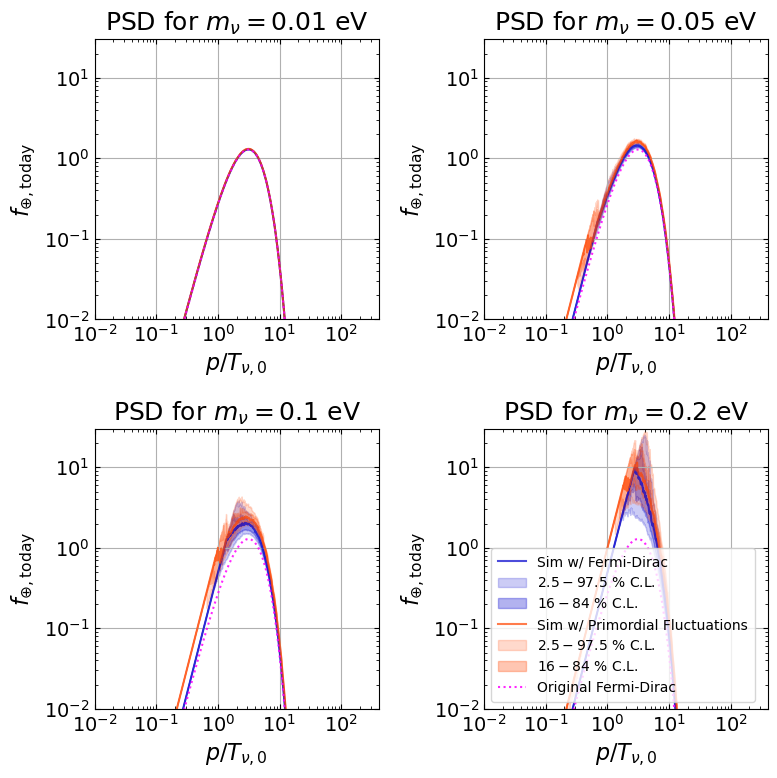

In [2]:
SimPlot.momentum_distributions_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=10, 
    fig_dir=fig_folder,
    args=Params())

## Temperature fluctuation skymaps from Cl

In [ ]:
SimPlot.temp_deltas_skymaps(
    m_Cl=0.01, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

SimPlot.temp_deltas_skymaps(
    m_Cl=0.05, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_dir=fig_folder,
    args=Params)

In [ ]:
print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
conv_unit = Primordial.uK/Params.T_CNB*100
TZ_val_left = -176166*conv_unit
TZ_val_right = 157773*conv_unit
print(f"{TZ_val_left:.4f} to {TZ_val_right:.4f} % of T_CNB")

## Comparison of FD & PF skymaps

In [ ]:
# Choose a halo and mass to display
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)

### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
print(f"Sum of FD skymap", FD_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF[halo_i, mPF_i, :] / skymap_norm
print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)  

## Comparison of FD & PF power spectra

In [ ]:
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in (0.01, 0.05, 0.1):
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD / skymap_norm, 
        pix_dens_PF=pix_dens_PF / skymap_norm, 
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)

## Percentage in certain velocity range

In [ ]:
def compute_percentages(v_arr, v_min, v_max, m_arr, args):

    vels_z0 = v_arr[:, 0, :]

    # Condition for having neutrinos with velocities in range, today
    mags_z0 = jnp.linalg.norm(vels_z0, axis=-1)*args.kpc/args.s
    cond = (v_min <= mags_z0) & (mags_z0 <= v_max)

    vels_range = v_arr[cond, ...]

    # Compute number densities for neutrinos in velocity range
    dens_range = Physics.number_densities_mass_range(
        vels_range, m_arr, 4*args.Pi, args)

    dens_total = Physics.number_densities_mass_range(
        v_arr, m_arr, 4*args.Pi, args)

    # Percentages 
    perc_range = dens_range/dens_total*100
    percs = [f"{perc:.3f}" for perc in perc_range]
    print(percs)


# Pick a halo
halo_i = 1

# Load velocities
vels = jnp.array(
    [jnp.load(f"{sim_folder}/vectors_halo{i+1}.npy") for i in range(10)]
)[0, ..., 3:].reshape((-1, 2, 3))
# ic(vels.shape)

vels_z0 = vels[:, 0, :]
# ic(vels_z0.shape)

vels_only_z0s = jnp.repeat(jnp.expand_dims(vels_z0, axis=1), repeats=2, axis=1)
# ic(vels_only_z0s.shape)

# Pick velocity range (as in https://arxiv.org/abs/1305.2454), units of c


v_min = 0.01
v_max = 0.14
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())

print("\n")

v_min = 0.001
v_max = 0.01
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())

## Number density via power spectra integration

In [ ]:
#?

## Momentum distributions

In [14]:
def momentum_distribution(y_arr, nbins, args):
    """
    Plot a momentum histogram with logarithmically spaced bins.
    """

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(y_arr)), np.log10(np.max(y_arr)), nbins)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        y_arr, bins=log_bins, 
        color="blue", label="CNB simulation", alpha=0.8)
    
    ax.set_xscale("log")
    ax.set_title("Momentum distribution at z=4 (Log Bins)")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()


# Load neutrino vectors for specified halo
halo = 1
nu_vectors = jnp.load(f'{sim_folder}/vectors_halo{halo}.npy')

# Convert to momenta
v_arr = nu_vectors[...,3:]
p_arr, y_arr = Physics.velocities_to_momenta_all_sky(
    v_arr, nu_m_picks, Params())
ic(v_arr.shape, p_arr.shape)

# for m_idx in range(len(nu_m_picks)):
for m_idx in range(1):

    # Set up plot parameters
    #? Changing the mass changes the FD momenta a lot, not seen in plot for m_idx=3
    z0_y_arr = y_arr[m_idx, ..., 0].reshape(-1,)
    z4_y_arr = y_arr[m_idx, ...,-1].reshape(-1,)#/(1+4)
    nbins = 50
    ic(z0_y_arr.shape)

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(z0_y_arr)), np.log10(np.max(z0_y_arr)), nbins)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)


    print('#? are the highest momenta affected by gravity? If yes how much?')
    last_x = 5
    print(jnp.count_nonzero(jnp.abs(z0_y_arr[-last_x:] - z4_y_arr[-last_x:])))
    print(jnp.abs(z0_y_arr[-last_x:] - z4_y_arr[-last_x:]))
    print('very little difference!\n')

    print('#? are the lowest momenta affected by gravity? If yes how much?')
    first_x = 5
    print(jnp.count_nonzero(jnp.abs(z0_y_arr[:first_x] - z4_y_arr[:first_x])))
    print(jnp.abs(z0_y_arr[:first_x] - z4_y_arr[:first_x]))
    print('more than 1 order of magnitude bigger difference than for higher momenta!\n')


    print("**************************************")
    print("Momentum endpoints for Cl(q) generation:")
    print(f"Min = {jnp.min(z4_y_arr)} T_CNB ; Max = {jnp.max(z4_y_arr)} T_CNB")
    print("**************************************\n")

    """
    # Sample Fermi-Dirac momenta
    samples = 1_000
    max_p = jnp.max(z0_y_arr*Params.T_CNB)
    print(f"Maximum momentum for Fermi-Dirac sampling = {max_p/Params.T_CNB:.4f} [T_CNB]\n")
    FD_momenta_z0 = Physics.sample_Fermi_Dirac_momentum(
        N=samples, T=Params.T_CNB, p_norm=max_p)
    # p_norm is the maximum momentum sampled, and is used for normalization

    FD_momenta_z4 = FD_momenta_z0*(1+4)

    # Randomly draw from simulation momenta, to match number of Fermi-Dirac samples
    z0_y_sync = jax.random.choice(Params.key, z0_y_arr, shape=(samples,), replace=False)
    z4_y_sync = jax.random.choice(Params.key, z4_y_arr, shape=(samples,), replace=False)

    # Plot momenta
    ax.hist(z0_y_sync, bins=log_bins, color="blue", label="Sim z=0", alpha=0.7)
    ax.hist(z4_y_sync, bins=log_bins, color="red", label="Sim z=4", alpha=0.7)
    ax.hist(FD_momenta_z4/Params.T_CNB, bins=log_bins, color="orange", label="FD z=4", alpha=0.7)

    ax.set_xscale("log")
    ax.set_title(rf"Momentum distribution (Log Bins) for $m_{{\nu}}={nu_m_picks[m_idx]}$")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()
    """

ic| v_arr.shape: (768, 1000, 2, 3), p_arr.shape: (5, 768, 1000, 2)
ic| z0_y_arr.shape: (768000,)


#? are the highest momenta affected by gravity? If yes how much?
5
[0.00038751 0.00038734 0.00038718 0.00038703 0.0003869 ]
very little difference!

#? are the lowest momenta affected by gravity? If yes how much?
5
[0.01048225 0.06456134 0.06435523 0.05421389 0.05425966]
more than 1 order of magnitude bigger difference than for higher momenta!

**************************************
Momentum endpoints for Cl(q) generation:
Min = 0.00023988810370910373 T_CNB ; Max = 13.286147226944964 T_CNB
**************************************

